# FAB-COST

The cells found below contain the code for the contextual bandit algorithm known as FAB-COST (ref?). 
For this demonstration the data is fed in as a batch although the algorithm could easily be tweeked to work with streming data. 


In [7]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import pylab
from random import randint
import matplotlib.patches as mpatches
import scipy as sp
from scipy import linalg
import sklearn
from ipynb.fs.full.Laplace_approximation import * # import definitions used for Laplace approximation

def sigmoid(x):
    sig = 1 / (1 + np.exp(-x))
    if(sig < 0.000000000001):
        sig = 0.000000000001
    return sig

def d_sigmoid(x):
    return np.exp(-x) / ((1 + np.exp(-x))*(1 + np.exp(-x)))   


Firstly, data must be fed into the algorithm in the form of a co-occurrence matrix $\mathbf{X} \in \mathbb{R}^{T \times K}$ (the input) and the binary vector $\mathbf{y} \in \mathbb{R}^T$ (the output). 
This can either be data fed in or simulated data. Due to UK data sensitivity laws, the Auto Trader dataset used in (ref?) cannot be uploaded here but a simulated dataset is used to show.

In [8]:
# simulated data in a single batch

d = 6 # number of covariates
H = np.ones(d)*(1/10**10) # vector of precision values
H = np.diag((H)) # initialises Hessian as identity
wprior = np.zeros((d)) # initialises prior vector
w = np.zeros((d)) # initialises weight vector
n = 50000 # number of samples
X = np.ones((n,d))
seed = 123 # use seed if needed 
batch_size = n
np.random.seed(seed)
for i in range(1,d): # random design matrix
    X[:,i] = np.random.rand(n)

beta = [1.0, 0.2, 1.5, -1.0, -0.7, -0.2] # weights 
z = beta[0]*X[:,0] + beta[1]*X[:,1] + beta[2]*X[:,2] + beta[3]*X[:,3] + beta[4]*X[:,4] + beta[5]*X[:,5] # linear combination of weights and covariates

pr = 1/(1 + np.exp(-z)) # logistic activation function
y = np.ones((n,1)) # initialise 
y = np.random.binomial(1,pr) # generate simulated observations from binomial distribution
y2 = y # copy for Laplace bandit
y_plot = y # used for plotting
y = y*2-1 # for EP and ADF calculations we require y = {-1,+1}
y3 = y
X = np.concatenate((np.arange(X.shape[0]).reshape(-1,1),X), axis=1) # add row count column
i_count = np.zeros(n,dtype=int)
X2 = X # copy X for Laplace bandit
i_count2 = i_count # copy for Laplace bandit


In [9]:
# Assumed Density Filtering TS

EP_update_point = 100 # at what point EP updates to give better estimate of posterior

var = 100 # initial local variance

V_global = (var)*np.eye(d) # initialise covariance matrix
m_global = np.zeros((d,1)) # initialise mean vector
i_count = np.zeros(n,dtype=int)

for t in range(0,EP_update_point):
    
    theta = np.random.multivariate_normal(np.ravel(m_global),V_global) # posterior sample
    i = np.argmax(X[:,1:X.shape[1]].dot(theta)) # find highest Thompson Sample
    i_count[t] = X[i,0]
    
    # Cavity not required with ADF
    Vmi = V_global
    mmi = m_global
            
    k = 1/np.sqrt(1+ ((np.pi/8)*np.inner(X[i,1:X.shape[1]].dot(Vmi),X[i,1:X.shape[1]]))) # Mackay's approximation constant (constant)
    zz = y[i]*(np.transpose(X[i,1:X.shape[1]]).dot(mmi))*k # k * x^T * m #######
    Z = sigmoid(zz) # logistic function
    d_Z = d_sigmoid(zz) # derivative of logistic function

    alpha_ep = y[i]*k*(d_sigmoid(zz)/sigmoid(zz))*(X[i,1:X.shape[1]][np.newaxis, :].T) # log-partition diff wrt mmi
    beta_ep = (-np.pi*k**2/16)*np.outer(X[i,1:X.shape[1]],X[i,1:X.shape[1]]).dot(np.outer(mmi,alpha_ep)) # log-partition diff wrt vmi
                             
    m_global = mmi + Vmi.dot(alpha_ep)# update of mean for approimating distribution q
    V_global = Vmi - Vmi.dot((np.outer(alpha_ep,alpha_ep) - 2*beta_ep)).dot(Vmi) # update of variance for approimating distribution q    
    
    X = np.delete(X,i,axis=0) # erase used row from X
    y = np.delete(y,i,axis=0) # erase used element from y

In [10]:
# EP initialisation
     
cycle = 4 # number of cycles thrugh factor graph
var = 100 # initial local variance
V_local = np.zeros((EP_update_point,d,d))
for i in range(0,EP_update_point):
    V_local[i] = (var)*np.eye(d) # V matrix (for local approximations)
V_global = np.eye(d) # v vector (for global approximations)
Vmi = np.ones((d,d)) # initialises vmi
m_local = np.zeros((EP_update_point,d)) # m matrix (for local approximations)
m_global = np.zeros((d,1)) # m vector (for global approximations)
mmi = np.ones((d,1)) # initialises mmi

Prec_ep = np.zeros((d,d))
for i in range(0,EP_update_point):
    Prec_ep = Prec_ep + np.linalg.pinv(V_local[i])
V_global = np.linalg.pinv(Prec_ep) # calculates global varaince (global precision = sum(local precisions))


In [11]:
# EP now gives accurate approximation at EP_update_point

for count in range(0,cycle): 
    for i in range(0,EP_update_point):
        
        # for each iteration i, a cavity distribtuion is formed. 
        Vmi = np.linalg.pinv( np.linalg.pinv( V_global ) - np.linalg.pinv( V_local[i] )) # variance vector for cavity(matrix)
        mmi = Vmi.dot((np.linalg.pinv( V_global ).dot(m_global) - np.linalg.pinv( V_local[i] ).dot(m_local[i][np.newaxis, :].T)))# mean for cavity(vector) check...
        
        k = 1/np.sqrt(1+ ((np.pi/8)*np.inner(X2[i_count[i],1:].dot(Vmi),X2[i_count[i],1:]))) # Mackay's approximation constant (constant)
        zz = y3[i_count[i]]*(np.transpose(X2[i_count[i],1:]).dot(mmi))*k 
        Z = sigmoid(zz) # logistic function
        d_Z = d_sigmoid(zz) # derivative of logistic function
        
        alpha_ep = y3[i_count[i]]*k*(d_sigmoid(zz)/sigmoid(zz))*(X2[i_count[i],1:][np.newaxis, :].T) # log-partition diff wrt mmi
        beta_ep = (-np.pi*k**2/16)*np.outer(X2[i_count[i],1:],X2[i_count[i],1:]).dot(np.outer(mmi,alpha_ep)) # log-partition diff wrt vmi
                             
        m_global = mmi + Vmi.dot(alpha_ep)# update of mean for approimating distribution q
        V_global = Vmi - Vmi.dot((np.outer(alpha_ep,alpha_ep) - 2*beta_ep)).dot(Vmi) # update of variance for approimating distribution q

        V_local[i] = np.linalg.pinv(np.linalg.pinv(V_global) - np.linalg.pinv(Vmi))
        m_local[i] = (V_local[i].dot( np.linalg.pinv(V_global).dot(m_global) - np.linalg.pinv(Vmi).dot(mmi) ))[:,np.newaxis].T
        


In [12]:
# ADF takeover

for t in range(EP_update_point,n):
    
    theta = np.random.multivariate_normal(np.ravel(m_global),V_global) # posterior sample
    i = np.argmax(X[:,1:X.shape[1]].dot(theta)) # find highest Thompson Sample
    i_count[t] = X[i,0]
    
    # Cavity not required with ADF
    Vmi = V_global
    mmi = m_global
            
    k = 1/np.sqrt(1+ ((np.pi/8)*np.inner(X[i,1:].dot(Vmi),X[i,1:]))) # Mackay's approximation constant (constant)
    zz = y[i]*(np.transpose(X[i,1:]).dot(mmi))*k # k * x^T * m #######
    Z = sigmoid(zz) # logistic function
    d_Z = d_sigmoid(zz) # derivative of logistic function

    alpha_ep = y[i]*k*(d_sigmoid(zz)/sigmoid(zz))*(X[i,1:][np.newaxis, :].T) # log-partition diff wrt mmi
    beta_ep = (-np.pi*k**2/16)*np.outer(X[i,1:],X[i,1:]).dot(np.outer(mmi,alpha_ep)) # log-partition diff wrt vmi
                             
    m_global = mmi + Vmi.dot(alpha_ep)# update of mean for approimating distribution q
    V_global = Vmi - Vmi.dot((np.outer(alpha_ep,alpha_ep) - 2*beta_ep)).dot(Vmi) # update of variance for approimating distribution q    
    
    X = np.delete(X,i,axis=0) # erase used row from X
    y = np.delete(y,i,axis=0) # erase used element from y
    

/Users/Jack/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  """


In [13]:
# Laplace TS

H = np.ones(d)*(1/10**2) # initialises Hessian (precision matrix) as identity (for Laplace)
H = np.diag((H)) # initialises Hessian as identity (for Laplace)
wprior = np.zeros((d)) # initialises prior vector
w = np.zeros((d))
X_L = np.empty((n,d)) # create empty X to later feed into Laplace 
y_L = np.empty(n) # create empty y to later feed into Laplace 


# First 10 iterations
for t in range(0,10):
    theta = np.random.multivariate_normal(np.ravel(w),np.linalg.inv(H)) # posterior sample
    i = np.argmax(X2[:,1:].dot(theta)) # find highest Thompson Sample
    i_count2[t] = X2[i,0]
    X_L[t,:] = X2[i,1:] # build X_L so batch inference can be performed 
    y_L[t] = y2[i]# build y_L so batch inference can be performed 
    X2 = np.delete(X2,i,axis=0) # erase used row from X
    y2 = np.delete(y2,i,axis=0) # erase used element from y


for t in range(10,n):
    
    theta = np.random.multivariate_normal(np.ravel(w),np.linalg.inv(H)) # posterior sample
    i = np.argmax(X2[:,1:].dot(theta)) # find highest Thompson Sample
    i_count2[t] = X2[i,0] # find original row of X
    X_L[t,:] = X2[i,1:] # build X_L so batch inference can be performed 
    y_L[t] = y2[i] # build y_L so batch inference can be performed 
    w, H = fit_bayes_logistic(y_L[0:t], X_L[0:t], wprior, H, weights=None, solver='Newton-CG', bounds=None, maxiter=1000)# Laplace inference  
    X2 = np.delete(X2,i,axis=0) # erase used row from X
    y2 = np.delete(y2,i,axis=0) # erase used element from y

In [14]:
action_reward_Laplace = np.zeros(n)
action_reward_FC = np.zeros(n)
cumilative_action_reward_Laplace = np.zeros(n)
cumilative_action_reward_FC = np.zeros(n)

for i in range(0,n):
    action_reward_Laplace[i] = y_plot[i_count2[i]]
    action_reward_FC[i] = y_plot[i_count[i]]
    
cumilative_action_reward_Laplace = np.cumsum(action_reward_Laplace)
cumilative_action_reward_FC = np.cumsum(action_reward_FC)


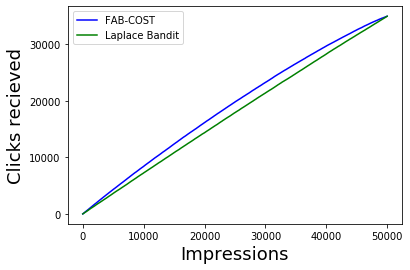

In [15]:
import matplotlib
x = np.arange(0, n)
plt.step(x, cumilative_action_reward_FC, label='FAB-COST',color='blue')
plt.step(x, cumilative_action_reward_Laplace, label='Laplace Bandit',color='green')
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rc('xtick', labelsize=15) 
plt.xlabel('Impressions', fontsize=18)
plt.ylabel('Clicks recieved', fontsize=18)
plt.title('', fontsize=18)
plt.legend()

No handles with labels found to put in legend.


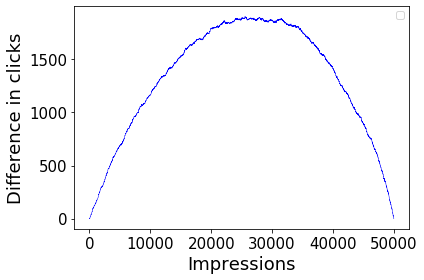

In [16]:
diff = cumilative_action_reward_FC - cumilative_action_reward_Laplace
x = np.arange(0, n)
plt.step(x, diff,color='blue',linewidth=0.5)
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rc('xtick', labelsize=15) 
plt.xlabel('Impressions', fontsize=18)
plt.ylabel('Difference in clicks', fontsize=18)
plt.title('', fontsize=18)
plt.tight_layout()
plt.savefig('FC_difference_in_clicks.pdf')
plt.legend()

No handles with labels found to put in legend.


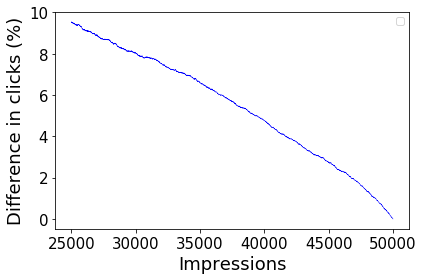

In [17]:
diff_percent = (cumilative_action_reward_FC - cumilative_action_reward_Laplace)/cumilative_action_reward_FC
x = np.arange(25000, n)
plt.step(x, diff_percent[25000:]*100,color='blue',linewidth=0.5)
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rc('xtick', labelsize=15) 
plt.xlabel('Impressions', fontsize=18)
plt.ylabel('Difference in clicks (%)', fontsize=18)
plt.title('', fontsize=18)
plt.tight_layout()
plt.savefig('FC_difference_in_clicks_percentage.pdf')
plt.legend()